In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


In [ ]:
import io

train = pd.read_csv("final_training_set.csv", engine="python")


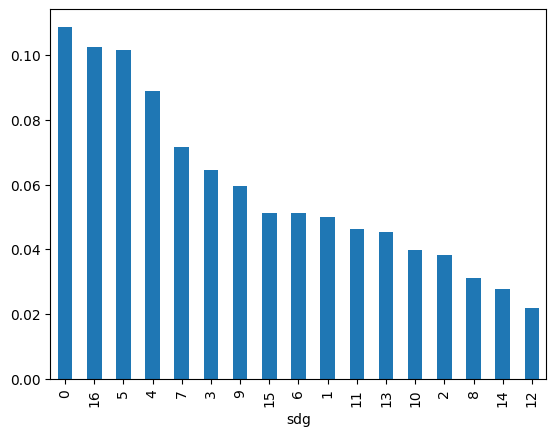

In [ ]:
# Making sure the proportion of sdg 0 is not too high
train["sdg"].value_counts(normalize=True).plot(kind='bar')

# Shuffle the data to avoid order bias
train = train.sample(frac=1, random_state=139390).reset_index(drop=True)


In [ ]:
# Spliting data between train, validation and test

from sklearn.model_selection import train_test_split

# Split into train (80%), temp (20%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    train["text"], train["sdg"],
    test_size=0.2,
    stratify=train["sdg"],  # Preserve class balance
    random_state=139390
)

# Split temp into val (10%) and test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
# Using the same tokenizer as the model

from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("sadickam/sdgBERT")

# Tokenize a batch of texts
def tokenize(batch_texts):
    return tokenizer(
        batch_texts,
        padding="max_length",    # Pad to max_length
        truncation=True,         # Truncate to max_length
        max_length=512,          # Match the original model's max length
        return_tensors="pt",     # Return PyTorch tensors
    )

# Example tokenization for training texts
tokenized_train = tokenize(train_texts.tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Create the pytorch dataset

from torch.utils.data import Dataset, DataLoader
import torch

class SDGDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = tokenize(texts.tolist())  # Tokenize all texts upfront

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.texts)

# Create datasets
train_dataset = SDGDataset(train_texts, train_labels)
val_dataset = SDGDataset(val_texts, val_labels)
test_dataset = SDGDataset(test_texts, test_labels)

In [ ]:
batch_size = 16  # Adjust based on GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,    # Shuffle for training
    num_workers=4    # Parallelize data loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,   # No need to shuffle validation
    num_workers=4
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "sadickam/sdgBERT",
    num_labels=17,  # 16 SDGs + residual
    ignore_mismatched_sizes=True  # Required to resize the classifier layer
)

# Verify model architecture
print(model.classifier)  # Should show `out_features=17`

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sadickam/sdgBERT and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([16]) in the checkpoint and torch.Size([17]) in the model instantiated
- classifier.weight: found shape torch.Size([16, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=17, bias=True)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)
model = model.to(device)

In [ ]:
#pip install tf-keras
#%pip install 'accelerate>=0.26.0'


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",          # Directory to save checkpoints
    learning_rate=2e-5,              # Match original BERT fine-tuning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=4,              # Start with 4 epochs
    weight_decay=0.01,               # Regularization
    evaluation_strategy="epoch",     # Evaluate after each epoch
    save_strategy="epoch",           # Save a checkpoint every epoch
    logging_dir="./logs",            # TensorBoard logs
    load_best_model_at_end=True,     # Keep the best model
    metric_for_best_model="eval_loss",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Compute loss with class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, 17), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


# Initialize Trainer with fixed compute_loss
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
# Train the model
trainer.train()

# Save the final model
trainer.save_model("sdgBERT_with_residual_final")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: msilvaservin (msilvaservin-university-college-dublin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
# Generate predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       0.85      0.81      0.83       161
           2       0.82      0.80      0.81       124
           3       0.95      0.95      0.95       208
           4       0.94      0.92      0.93       286
           5       0.92      0.89      0.91       327
           6       0.93      0.87      0.90       165
           7       0.93      0.87      0.90       231
           8       0.65      0.73      0.69       100
           9       0.85      0.95      0.90       192
          10       0.81      0.76      0.78       129
          11       0.83      0.89      0.86       149
          12       0.82      0.94      0.88        70
          13       0.87      0.88      0.87       146
          14       0.94      0.94      0.94        89
          15       0.87      0.89      0.88       166
          16       0.98      0.99      0.98       330

    accuracy              

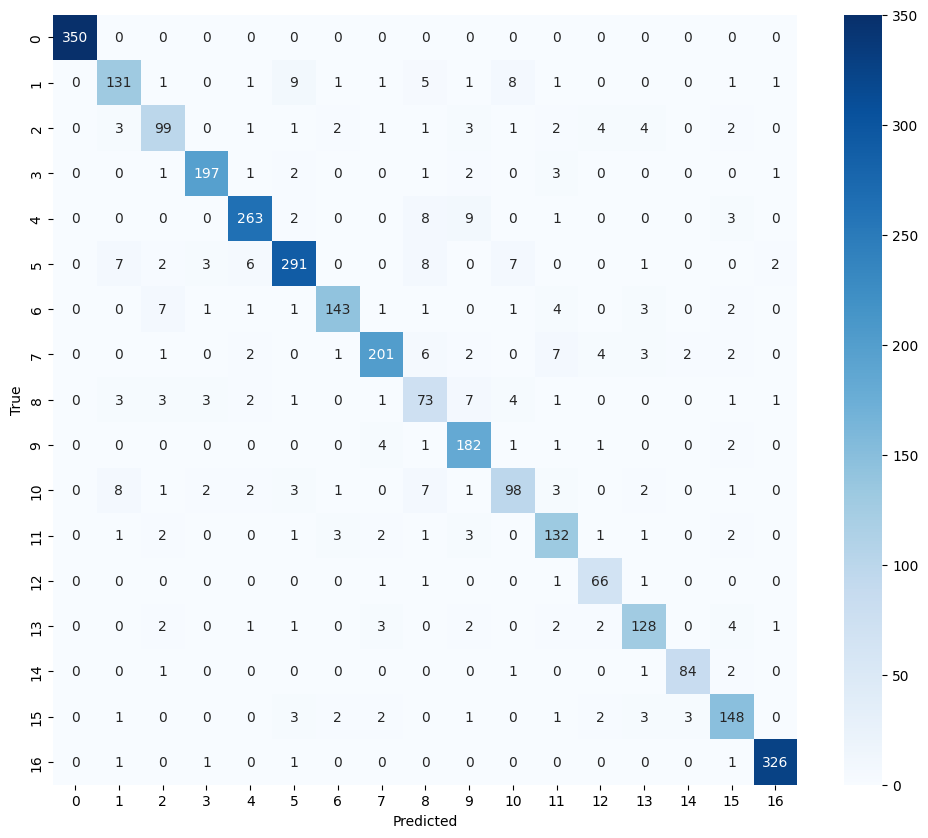

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="sdgBERT_with_residual_final",
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cuda:0


In [ ]:
# prompt: I want to download my model with the following files:
# config.json
# pytorch_model.bin (or model.safetensors)
# tokenizer.json
# tokenizer_config.json
# vocab.txt
# special_tokens_map.json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from transformers import pipeline

# The provided code already contains model training, so we are just adding the code to download the model files.

# Load the tokenizer that was used in the training process
tokenizer = AutoTokenizer.from_pretrained("sadickam/sdgBERT")

# Create a directory for the tokenizer if it doesn't exist.
!mkdir -p sdgBERT_with_residual_final/tokenizer

# Save the tokenizer in the correct directory with required files
tokenizer.save_pretrained("sdgBERT_with_residual_final/tokenizer")

# Save the model locally (already done in the original code)
# !zip -r sdgBERT_with_residual_final.zip sdgBERT_with_residual_final/

# Create a zip archive of the model folder
!zip -r sdgBERT_with_residual_final.zip sdgBERT_with_residual_final/

# Download the zip file containing the model and tokenizer
files.download('sdgBERT_with_residual_final.zip')


updating: sdgBERT_with_residual_final/ (stored 0%)
updating: sdgBERT_with_residual_final/training_args.bin (deflated 52%)
updating: sdgBERT_with_residual_final/config.json (deflated 60%)
updating: sdgBERT_with_residual_final/model.safetensors (deflated 7%)
  adding: sdgBERT_with_residual_final/tokenizer/ (stored 0%)
  adding: sdgBERT_with_residual_final/tokenizer/vocab.txt (deflated 53%)
  adding: sdgBERT_with_residual_final/tokenizer/tokenizer_config.json (deflated 75%)
  adding: sdgBERT_with_residual_final/tokenizer/tokenizer.json (deflated 71%)
  adding: sdgBERT_with_residual_final/tokenizer/special_tokens_map.json (deflated 80%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>